# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 28.01.2022

Мягкий дедлайн: 23:59MSK 14.02.2022

Жесткий дедлайн: 23:59MSK 17.02.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [59]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)

            X_pca = self.pca.fit_transform(X)
    
            dim = self.new_dim
        else:
            X_pca = X
            dim = len(X.T)
        
        rand = np.random.randint(len(X) - 1, size=[2, 10**6]).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X_pca[rand][:, 0] - X_pca[rand][:, 1]) ** 2, axis=1)))
        w = np.random.normal(0, 1 / sigma, size=(self.n_features, dim))
        b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        X_kernel = np.cos((X_pca @ w.T) + b)
        
        if self.classifier == 'svm':
            model = SVC(kernel='linear', probability=True)
        else:
            model = LogisticRegression(max_iter=10**4)
        
        model.fit(X_kernel, y)
        
        self.w = w
        self.b = b
        self.model = model
        
        return self

    def predict_proba(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            pass
        
        X = np.cos((X @ self.w.T) + self.b)
        
        return self.model.predict_proba(X)
        
    def predict(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            pass
        
        X = np.cos((X @ self.w.T) + self.b)
        
        return self.model.predict(X)

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
svm_rff = RFFPipeline(classifier='svm').fit(x_train[:15000], y_train[:15000])
y_rff = svm_rff.predict(x_test)
accuracy_score(y_rff, y_test)

In [4]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [5]:
svm = dict()
svm['linear'] = LinearSVC(max_iter=10**4)
svm['kernel'] = SVC(kernel='rbf')
svm['rff'] = RFFPipeline(classifier='svm', use_PCA=False)

In [6]:
fit_time = dict()
prediction_time = dict()
accuracy = dict()

for model in ['linear', 'kernel', 'rff']:
    fit_start = time.time()
    svm[model].fit(x_train_pca[:10000], y_train[:10000])
    fit_time[model] = time.time() - fit_start
    
    pred_start = time.time()
    y_pred = svm[model].predict(x_test_pca)
    prediction_time[model] = time.time() - pred_start
    
    accuracy[model] = accuracy_score(y_pred, y_test)

In [7]:
accuracy

{'linear': 0.6528, 'kernel': 0.848, 'rff': 0.8528}

In [12]:
fit_time

{'linear': 185.08938241004944,
 'kernel': 2.405912160873413,
 'rff': 151.1536545753479}

In [13]:
prediction_time

{'linear': 0.007741689682006836,
 'kernel': 3.6356630325317383,
 'rff': 53.32275724411011}

In [8]:
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=165)

In [9]:
scaler = StandardScaler()
x_train_val_sc = scaler.fit_transform(x_train_val)
x_val_sc = scaler.transform(x_val)
x_test_sc = scaler.transform(x_test)

PCA = PCA(n_components=50)
x_train_val_sc_pca = PCA.fit_transform(x_train_val_sc)
x_val_sc_pca = PCA.transform(x_val_sc)
x_test_sc_pca = PCA.transform(x_test_sc)

In [10]:
iteration_list = [20, 50, 80, 110, 140, 170]
lr_list = [0.01, 0.05, 0.1, 0.2, 0.3]
accuracy_lgb = dict()

for num_iterations in iteration_list:
    for lr in lr_list:
        lgb = LGBMClassifier(num_iterations=num_iterations, learning_rate=lr).fit(x_train_val_sc_pca, y_train_val)
        y_pred = lgb.predict(x_val_sc_pca)
        
        accuracy_lgb[num_iterations, lr] = accuracy_score(y_pred, y_val)

In [11]:
num_iterations, lr = max(accuracy_lgb, key=accuracy_lgb.get)

In [14]:
num_iterations, lr

(170, 0.2)

In [15]:
fit_start_lgb = time.time()
lgb = LGBMClassifier(num_iterations=num_iterations, learning_rate=lr).fit(x_train_val_sc_pca[:10000], y_train_val[:10000])
fit_time['lgb'] = time.time() - fit_start_lgb

In [16]:
pred_start_lgb = time.time()
y_pred_lgb = lgb.predict(x_test_sc_pca)
prediction_time['lgb'] = time.time() - pred_start_lgb

In [17]:
accuracy['lgb'] = accuracy_score(y_pred_lgb, y_test)

In [18]:
accuracy, fit_time, prediction_time

({'linear': 0.6528, 'kernel': 0.848, 'rff': 0.8528, 'lgb': 0.8503},
 {'linear': 185.08938241004944,
  'kernel': 2.405912160873413,
  'rff': 151.1536545753479,
  'lgb': 6.595494508743286},
 {'linear': 0.007741689682006836,
  'kernel': 3.6356630325317383,
  'rff': 53.32275724411011,
  'lgb': 0.5252702236175537})

Как можно заметить, по времени обучения самым затратным является svm на исходных признаках с линейным ядром, далее идет svm на случайных признаках (время обучения соизмеримо). При этом время обучения для lightgbm и svm на гауссовском ядре отличается на два порядка. 

Ситуация с применением немного иная: svm на линейном ядре совершает предсказания практически мгновенно (что довольно ожидаемо), в то время как применение svm на случайных признаках оказалось самым долгим

Что касается качества, то здесь бустинг и svm на случайных признаках показали соизмеримое качество.

Таким образом, можно сделать вывод о том, что, учитывая три приведенных показателя, lightgbm является более предпочтительным, чем svm на случайных признаках и svm на исходных с линейным ядром

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [20]:
scaler_test = StandardScaler()
x_train_sc = scaler_test.fit_transform(x_train)
x_test_sc = scaler_test.transform(x_test)

In [40]:
svm = RFFPipeline(classifier='svm', use_PCA=False)
svm_pca = RFFPipeline(classifier='svm')

In [22]:
fit_time = dict()
prediction_time = dict()
accuracy = dict()

In [41]:
start_svm = time.time()
svm.fit(x_train_sc[:10000], y_train[:10000])
fit_time['svm no pca'] = time.time() - start_svm

start_svm_pca = time.time()
svm_pca.fit(x_train_sc[:10000], y_train[:10000])
fit_time['svm pca'] = time.time() - start_svm_pca

In [42]:
pred_start_svm = time.time()
y_svm_pred = svm.predict(x_test_sc)
prediction_time['svm no pca'] = time.time() - pred_start_svm

pred_start_svm_pca = time.time()
y_svm_pca_pred = svm_pca.predict(x_test_sc)
prediction_time['svm pca'] = time.time() - pred_start_svm_pca

In [43]:
accuracy['svm no pca'] = accuracy_score(y_svm_pred, y_test)
accuracy['svm pca'] = accuracy_score(y_svm_pca_pred, y_test)

In [45]:
accuracy

{'svm no pca': 0.8315, 'svm pca': 0.8494}

In [46]:
fit_time

{'svm no pca': 177.53473567962646, 'svm pca': 157.46567058563232}

In [47]:
prediction_time

{'svm no pca': 62.889227628707886, 'svm pca': 53.39995574951172}

Если рассматривать только приведенные показатели (качество, время обучения, время предикта), то очевидно, что использование pca дает ощутимое преимущество как при обучении, так и при применении

In [48]:
accuracy_test_svm = dict()
accuracy_test_logreg = dict()

for n_features in [100, 200, 300, 500, 700, 1000, 1300, 1600, 2000, 2500, 3100]:
    svm_test = RFFPipeline(n_features=n_features, classifier='svm').fit(x_train_sc[:10000], y_train[:10000])
    y_pred_svm = svm_test.predict(x_test_sc)
    
    logreg_test = RFFPipeline(n_features=n_features, classifier='logreg').fit(x_train_sc[:10000], y_train[:10000])
    y_pred_logreg = logreg_test.predict(x_test_sc)
    
    accuracy_test_svm[n_features] = accuracy_score(y_pred_svm, y_test)
    accuracy_test_logreg[n_features] = accuracy_score(y_pred_logreg, y_test) 

KeyboardInterrupt: 

Обучил до 2500, так как не успевал((

In [51]:
accuracy_test_svm, accuracy_test_logreg

({100: 0.8325,
  200: 0.8394,
  300: 0.8433,
  500: 0.8471,
  700: 0.8438,
  1000: 0.8449,
  1300: 0.8441,
  1600: 0.8466,
  2000: 0.8438,
  2500: 0.8419},
 {100: 0.8238,
  200: 0.8398,
  300: 0.8405,
  500: 0.8429,
  700: 0.8453,
  1000: 0.8487,
  1300: 0.8509,
  1600: 0.8513,
  2000: 0.8502,
  2500: 0.8513})

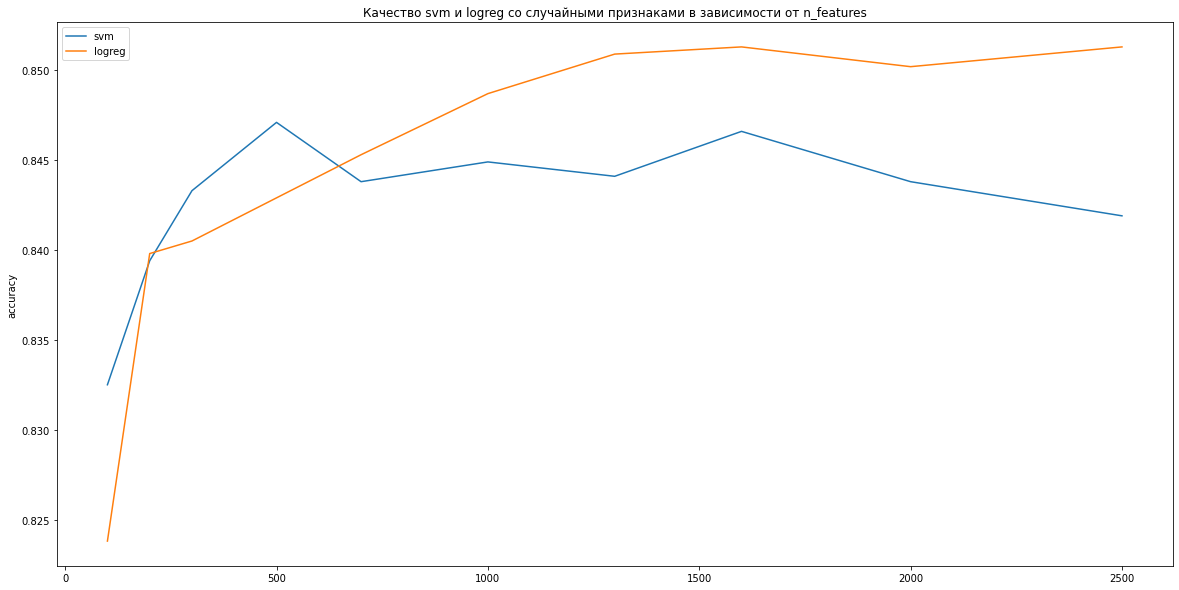

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=accuracy_test_svm, ax=ax)
sns.lineplot(data=accuracy_test_logreg, ax=ax)
ax.legend(['svm', 'logreg'])
ax.set_ylabel('accuracy')
ax.set_title('Качество svm и logreg со случайными признаками в зависимости от n_features');

По построенному графику видно, что со значения n_features = 500 svm выходит на плато, в то время как logreg только с 1200-1300

Также стоит отметить, что logreg выдает в среднем более высокое качество (после n_features = 700 качество logreg не опускается ниже svm), поэтому при обучении на случайных признаках данная модель является более предпочтительной (если рассматривать только качество)

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline_func(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
        
    def fit(self, X, y):
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)

            X_pca = self.pca.fit_transform(X)
    
            dim = self.new_dim
        else:
            X_pca = X
            dim = len(X.T)
        
        rand = np.random.randint(len(X) - 1, size=[2, 10**6]).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X_pca[rand][:, 0] - X_pca[rand][:, 1]) ** 2, axis=1)))
        w = np.random.normal(0, 1 / sigma, size=(self.n_features, dim))
        b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        X_kernel = self.func((X_pca @ w.T) + b)
        
        if self.classifier == 'svm':
            model = SVC(kernel='linear', probability=True)
        else:
            model = LogisticRegression(max_iter=10**4)
        
        model.fit(X_kernel, y)
        
        self.w = w
        self.b = b
        self.model = model
        
        return self

    def predict_proba(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            pass
        
        X = self.func((X @ self.w.T) + self.b)
        
        return self.model.predict_proba(X)
        
    def predict(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)
        else:
            pass
        
        X = self.func((X @ self.w.T) + self.b)
        
        return self.model.predict(X)

In [78]:
model = RFFPipeline_func(func=np.cos).fit(x_train_sc[:5000], y_train[:5000])
y_func_pred = model.predict(x_test_sc)
accuracy_score(y_func_pred, y_test)

0.8361

In [75]:
model = RFFPipeline_func(func=np.cosh).fit(x_train_sc[:5000], y_train[:5000])
y_func_pred = model.predict(x_test_sc)
accuracy_score(y_func_pred, y_test)

0.7698

In [80]:
model = RFFPipeline_func(func=np.sign).fit(x_train_sc[:5000], y_train[:5000])
y_func_pred = model.predict(x_test_sc)
accuracy_score(y_func_pred, y_test)

0.767

In [81]:
model = RFFPipeline_func(func=np.tanh).fit(x_train_sc[:5000], y_train[:5000])
y_func_pred = model.predict(x_test_sc)
accuracy_score(y_func_pred, y_test)

0.8333

Мы убедились в том, что ни одна из приведенных функций не смогла выдать качество выше косинуса